# Importar librerias

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from pycaret.regression import setup
import statsmodels.api as sm

# Funciones auxiliares

In [8]:
def matriz_correlacion(dataset, target):
    corr_matrix = dataset.corr()
    corr_matrix[target].sort_values(ascending=False)
    #from matplotlib.colors import ListedColormap
    #cm_blue_orange = ListedColormap(['tab:blue', 'orange'])
    cm_red_blue = mpl.colormaps['RdBu']
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cm_red_blue, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Heatmap con Valores Numéricos y Colores')
    # Mostrar el gráfico
    plt.show()

In [9]:
# Calcular el VIF para cada característica
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [10]:
# Función para entrenar y evaluar un modelo
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calcular RMSE
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [11]:
'''eliminación_hacia_atras https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLSResults.html

dataset: datos a entrenar (dataframe)
level_significance: nivel de significancia, por default 0.05

Este método hace la eliminación hacia atrás de la regresión lineal múltiple de acuerdo a un nivel de significancia (p valor)
utilizando como métrica al valor r cuadrado ajustado.
Return: Arroja una lista de los nombres de las variables más significativas para el modelo'''
def eliminacion_hacia_atras(dataset:pd.DataFrame, target:str, level_significance = 0.05):
    X = dataset.loc[:, (dataset.columns != target)]
    y = dataset.loc[:, target]
    columnas_X = X.columns.tolist()
    
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=123)
    X_train = pd.DataFrame(X_train, columns=X.columns)  # Reconstruir DataFrame para entrenamiento
    y_train = pd.Series(y_train)
    y_train.name = target

    #preparar los predictores para función OLS
    #Se agrega una columna de '1' (constante) al inicio a los predictores para el método OLS (obligatorio)
    X_OLS = sm.add_constant(X_train)
    y_OLS = y_train
    
    rsquared_adj_dictionary = {} #clave: r cuadrado ajustado, valor: nombre de las variable independiente

    while len(columnas_X) > 0:
        regression_OLS = sm.OLS(endog = y_OLS, exog = X_OLS).fit()
        
        pvalues = regression_OLS.pvalues.iloc[1:] #Se tiene los p valores del modelo // No se escoge la columna llena de 1 (constante)
        max_p_value = max(pvalues) #el mayor p valor
        model_rsquared_adj = regression_OLS.rsquared_adj # r2 ajustado del modelo

        feature_to_remove = pvalues.idxmax() #nombre de la variable a eliminar (p valor max)
        rsquared_adj_dictionary[model_rsquared_adj] = columnas_X.copy()

        #Print de los resultados estadísticos (opcional - se puede comentar)
        print('*'*80)
        print(regression_OLS.summary(), end= '\n'*2)
        print('Criterio de Información de Akaike (AIC), debe ser preferiblemente el menor entre todos los modelos:', regression_OLS.aic)
        print(rsquared_adj_dictionary[model_rsquared_adj])
        print('*'*80, end= '\n'*4)
        #Print de los resultados estadísticos (opcional - se puede comentar)

        if max_p_value > level_significance:

            X_OLS = X_OLS.drop(columns=[feature_to_remove])
            columnas_X.remove(feature_to_remove)
        else: #si ya se superó el umbral de significancia se para el ciclo while
            break

    maximo_r2_adj = max(rsquared_adj_dictionary)

    #Print de los resultados (opcional - se puede comentar)
    print('//ESTE ES EL MEJOR MODELO')
    print(f"R^2: {maximo_r2_adj}, variables de este modelo: {rsquared_adj_dictionary[maximo_r2_adj]}")
    #Print de los resultados (opcional - se puede comentar)

    return rsquared_adj_dictionary[maximo_r2_adj] + [target]

# Preprocesamiento

In [12]:
average_cluster_1=pd.read_csv("../data/interim/closest_series_cluster_1.csv",parse_dates=["Date/Time"])

In [13]:
#eliminamos la columna type building porque no es relevante 
average_cluster_1.drop(columns=["type_building"], inplace=True)

In [14]:
average_cluster_1.shape

(8760, 7)

In [15]:
average_cluster_1.head()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,377.173911,22.142737,78.943162,0.0,24.920364,149.522181
1,2004-01-01 02:00:00,350.282947,18.452281,63.343172,0.0,24.920364,149.522181
2,2004-01-01 03:00:00,376.426031,23.065351,77.234495,0.0,24.920364,149.522181
3,2004-01-01 04:00:00,350.215700,18.452281,63.051518,0.0,24.920364,149.522181
4,2004-01-01 05:00:00,390.337565,23.065351,78.315875,0.0,24.920364,149.522181


In [16]:
average_cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date/Time                                   8395 non-null   datetime64[ns]
 1   Electricity:Facility [kW](Hourly)           8760 non-null   float64       
 2   Fans:Electricity [kW](Hourly)               8760 non-null   float64       
 3   Cooling:Electricity [kW](Hourly)            8760 non-null   float64       
 4   Heating:Electricity [kW](Hourly)            8760 non-null   float64       
 5   InteriorLights:Electricity [kW](Hourly)     8760 non-null   float64       
 6   InteriorEquipment:Electricity [kW](Hourly)  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 479.2 KB


In [17]:
average_cluster_1.isna().sum()

Date/Time                                     365
Electricity:Facility [kW](Hourly)               0
Fans:Electricity [kW](Hourly)                   0
Cooling:Electricity [kW](Hourly)                0
Heating:Electricity [kW](Hourly)                0
InteriorLights:Electricity [kW](Hourly)         0
InteriorEquipment:Electricity [kW](Hourly)      0
dtype: int64

In [18]:
average_cluster_1.iloc[:5,:]

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,377.173911,22.142737,78.943162,0.0,24.920364,149.522181
1,2004-01-01 02:00:00,350.282947,18.452281,63.343172,0.0,24.920364,149.522181
2,2004-01-01 03:00:00,376.426031,23.065351,77.234495,0.0,24.920364,149.522181
3,2004-01-01 04:00:00,350.215700,18.452281,63.051518,0.0,24.920364,149.522181
4,2004-01-01 05:00:00,390.337565,23.065351,78.315875,0.0,24.920364,149.522181


In [19]:
average_cluster_1[average_cluster_1.isna().any(axis=1)]

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
23,NaT,370.469652,18.452281,68.034494,0.0,24.920364,149.522181
47,NaT,321.715715,1.173458,1.588921,0.0,24.920364,199.362908
71,NaT,330.173409,1.955763,1.211960,0.0,24.920364,199.362908
95,NaT,394.852940,9.265539,67.934570,0.0,24.920364,199.362908
119,NaT,299.992125,0.000000,0.000000,0.0,24.920364,199.362908
...,...,...,...,...,...,...,...
8663,NaT,299.992110,0.000000,0.000000,0.0,24.920364,199.362908
8687,NaT,299.992112,0.000000,0.000000,0.0,24.920364,199.362908
8711,NaT,299.992113,0.000000,0.000000,0.0,24.920364,199.362908
8735,NaT,250.151388,0.000000,0.000000,0.0,24.920364,149.522181


In [20]:
# # Imputar o eliminar valores faltantes si existen
# average_cluster_0.fillna(method='ffill', inplace=True)
average_cluster_1['Date/Time'].fillna(pd.Timestamp('2004-01-01 00:00:00'), inplace=True)

In [21]:
average_cluster_1.isna().sum()

Date/Time                                     0
Electricity:Facility [kW](Hourly)             0
Fans:Electricity [kW](Hourly)                 0
Cooling:Electricity [kW](Hourly)              0
Heating:Electricity [kW](Hourly)              0
InteriorLights:Electricity [kW](Hourly)       0
InteriorEquipment:Electricity [kW](Hourly)    0
dtype: int64

In [22]:
# Establecer la columna de fecha como índice
average_cluster_1.set_index('Date/Time', inplace=True)

In [23]:
# Extraer características temporales
average_cluster_1['hour'] = average_cluster_1.index.hour
average_cluster_1['day_of_week'] = average_cluster_1.index.dayofweek
average_cluster_1['month'] = average_cluster_1.index.month

In [24]:
average_cluster_1.head()

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),hour,day_of_week,month
Date/Time,,,,,,,,,
2004-01-01 01:00:00,377.173911,22.142737,78.943162,0.0,24.920364,149.522181,1,3,1
2004-01-01 02:00:00,350.282947,18.452281,63.343172,0.0,24.920364,149.522181,2,3,1
2004-01-01 03:00:00,376.426031,23.065351,77.234495,0.0,24.920364,149.522181,3,3,1
2004-01-01 04:00:00,350.215700,18.452281,63.051518,0.0,24.920364,149.522181,4,3,1
2004-01-01 05:00:00,390.337565,23.065351,78.315875,0.0,24.920364,149.522181,5,3,1


In [25]:
average_cluster_1.columns

Index(['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month'],
      dtype='object')

In [26]:
target='Electricity:Facility [kW](Hourly)'

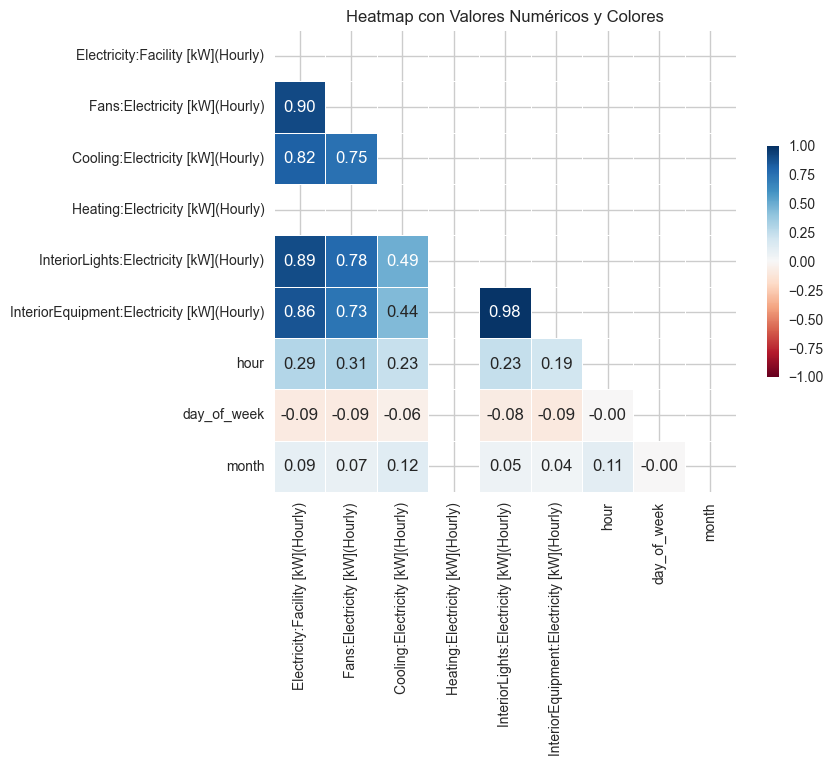

In [27]:
matriz_correlacion(average_cluster_1, target)

In [28]:
dataset_sin_correlacion = average_cluster_1.reset_index(drop=True).copy()
multicollinearity_threshold = 0.6 #definir umbral para eliminar las variables altamente correlacionadas entre sí 
sin_correlacion = setup(data = dataset_sin_correlacion, target = target, remove_multicollinearity = True, multicollinearity_threshold = multicollinearity_threshold) #se eliminan los valores con correlación mayor a "multicollinearity_threshold"

,Description,Value
0,Session id,6330
1,Target,Electricity:Facility [kW](Hourly)
2,Target type,Regression
3,Original data shape,"(8760, 9)"
4,Transformed data shape,"(8760, 6)"
5,Transformed train set shape,"(6132, 6)"
6,Transformed test set shape,"(2628, 6)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [29]:
lista_sin_correlacion = sin_correlacion.dataset_transformed.columns.to_list()
lista_sin_correlacion

['FansElectricity kW(Hourly)',
 'HeatingElectricity kW(Hourly)',
 'hour',
 'day_of_week',
 'month',
 'Electricity:Facility [kW](Hourly)']

In [30]:
lista_sin_correlacion_p=["Electricity:Facility [kW](Hourly)",'Heating:Electricity [kW](Hourly)','InteriorLights:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month']

In [31]:
dataset_sin_correlacion = dataset_sin_correlacion.loc[:,lista_sin_correlacion_p]

In [32]:
dataset_sin_correlacion.head()

,Electricity:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),hour,day_of_week,month
0,377.173911,0.0,24.920364,1,3,1
1,350.282947,0.0,24.920364,2,3,1
2,376.426031,0.0,24.920364,3,3,1
3,350.215700,0.0,24.920364,4,3,1
4,390.337565,0.0,24.920364,5,3,1


In [33]:
features_corr=dataset_sin_correlacion.drop(columns='Electricity:Facility [kW](Hourly)').copy()

**Evaluación de la Multicolinealidad**

* La multicolinealidad ocurre cuando dos o más variables están altamente correlacionadas entre sí.

* Esto puede causar problemas en los modelos de regresión porque dificulta determinar el efecto individual de cada variable.
  
**¿Cómo evaluamos la multicolinealidad?**

* Usamos el Factor de Inflación de la Varianza (VIF). Un VIF alto (mayor a 10) indica multicolinealidad alta.

* Eliminamos las variables con VIF mayor a 10 para reducir la multicolinealidad y simplificar nuestro modelo.

In [34]:
# Paso 3: Evaluación de la Multicolinealidad
vif_before_corr = calculate_vif(features_corr)
vif_before_corr

,feature,VIF
0,Heating:Electricity [kW](Hourly),NaN
1,InteriorLights:Electricity [kW](Hourly),2.011680
2,hour,3.316556
3,day_of_week,2.449894
4,month,3.045272


In [35]:
features_selected_corr=features_corr.copy()
features_selected_corr.head()


,Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),hour,day_of_week,month
0,0.0,24.920364,1,3,1
1,0.0,24.920364,2,3,1
2,0.0,24.920364,3,3,1
3,0.0,24.920364,4,3,1
4,0.0,24.920364,5,3,1


In [36]:
taget_predict=dataset_sin_correlacion.loc[:,'Electricity:Facility [kW](Hourly)'].copy()

In [37]:
lista_eliminicacion_hacia_atras = eliminacion_hacia_atras(dataset_sin_correlacion,target)

********************************************************************************
                                    OLS Regression Results                                   
Dep. Variable:     Electricity:Facility [kW](Hourly)   R-squared:                       0.802
Model:                                           OLS   Adj. R-squared:                  0.802
Method:                                Least Squares   F-statistic:                     7109.
Date:                               Tue, 06 Aug 2024   Prob (F-statistic):               0.00
Time:                                       01:29:09   Log-Likelihood:                -47251.
No. Observations:                               7008   AIC:                         9.451e+04
Df Residuals:                                   7003   BIC:                         9.455e+04
Df Model:                                          4                                         
Covariance Type:                           nonrobust                     

In [38]:
lista_eliminicacion_hacia_atras

['Heating:Electricity [kW](Hourly)',
 'InteriorLights:Electricity [kW](Hourly)',
 'hour',
 'day_of_week',
 'month',
 'Electricity:Facility [kW](Hourly)']

In [39]:
lista_sin_correlacion_p=['Heating:Electricity [kW](Hourly)','InteriorLights:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month']

In [40]:
features_predict=average_cluster_1.loc[:,lista_sin_correlacion_p].copy()

In [41]:
taget_predict=dataset_sin_correlacion.loc[:,'Electricity:Facility [kW](Hourly)'].copy()

# Seleccion del modelo

In [42]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(features_predict, taget_predict, test_size=0.2, random_state=42)

In [43]:
# Escalar las características
scaler_corr = StandardScaler()
X_train_scaled_corr = scaler_corr.fit_transform(X_train_corr)
X_test_scaled_corr = scaler_corr.transform(X_test_corr)

In [44]:
# Definir los modelos
models = {
    "Linear Regression": LinearRegression(),
    "Stepwise Linear Regression": Lasso(alpha=0.01),  # Utilizando Lasso como aproximación a la regresión paso a paso
    "Tree": DecisionTreeRegressor(),
    "SVM": SVR(kernel='rbf'),
    "Efficient Linear": LinearRegression(),  # Utilizando Linear Regression como proxy
    "Ensemble": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Variables para almacenar resultados
results = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    rmse, r2 = train_evaluate_model(model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)
    results[model_name] = {'RMSE': rmse, 'R2 Score': r2}

In [45]:
# Convertir a DataFrame
df_results = pd.DataFrame(results)
df_results.head()

,Linear Regression,Stepwise Linear Regression,Tree,SVM,Efficient Linear,Ensemble,Random Forest
RMSE,201.346823,201.348034,122.048348,200.510555,201.346823,123.418934,116.847430
R2 Score,0.813959,0.813956,0.931643,0.815501,0.813959,0.930099,0.937345


In [46]:
# Entrenar el modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo de Random Forest
rmse_train_rf, r2_train_rf = train_evaluate_model(rf_model, X_train_scaled_corr, X_train_scaled_corr, y_train_corr, y_train_corr)
rmse_test_rf, r2_test_rf = train_evaluate_model(rf_model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)

# Resultados
rf_results = {
    "Random Forest": {
        'RMSE Train': rmse_train_rf, 
        'R2 Train': r2_train_rf,
        'RMSE Test': rmse_test_rf, 
        'R2 Test': r2_test_rf
    }
}

In [47]:
# Convertir a DataFrame y verificar overfitting
df_overfitting_results= pd.DataFrame(rf_results)
df_overfitting_results.head()

,Random Forest
R2 Test,0.937345
R2 Train,0.967388
RMSE Test,116.847430
RMSE Train,83.580862


# Mejorar hiperparametros

In [41]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Validación cruzada de 3 pliegues
                           n_jobs=-1,  # Usar todos los núcleos disponibles
                           scoring='neg_root_mean_squared_error',  # Usar RMSE
                           verbose=2)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train_scaled_corr, y_train_corr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [42]:
print("Mejores hiperparámetros:", best_params)

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [43]:
# Entrenar el modelo con los mejores hiperparámetros
optimized_rf_model = RandomForestRegressor(**best_params, random_state=42)
optimized_rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo optimizado
rmse_train_opt = np.sqrt(mean_squared_error(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr)))
r2_train_opt = r2_score(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))

rmse_test_opt = np.sqrt(mean_squared_error(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr)))
r2_test_opt = r2_score(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))

# Resultados
optimized_rf_results = {
    "Optimized Random Forest": {
        'RMSE Train': rmse_train_opt,
        'R2 Train': r2_train_opt,
        'RMSE Test': rmse_test_opt,
        'R2 Test': r2_test_opt
    }
}

In [44]:
# Mostrar los resultados
print("Resultados del modelo Random Forest optimizado:")
optimized_rf_results_df=pd.DataFrame(optimized_rf_results)
optimized_rf_results_df

,Optimized Random Forest
MSE Test,0.921139
MSE Train,0.156282
R2 Test,0.998850
R2 Train,0.999803
